In [1]:
import os

modelname = 'src/model1.1.1Llocal'

os.system('mkdir ./'+modelname)
outputf = open(modelname+'/output.txt', 'w')

outputf.write('OMP_NUM_THREADS = '+str( os.popen('echo $OMP_NUM_THREADS').read()) +'\n\n')

21

In [2]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import keras, os, struct

Using TensorFlow backend.


In [3]:
#lsstr = "ls /home/xiaodongli/data/colas/cola_multiverse/om_As/"
lsstr = "ls /media/xiaodongli/0B9ADFB4341AD2BD/om_As/"

def cosmostr(om, As):
    return 'om%.3f' % om + '_As%.3f' % As

def snpfiles(cosmology, snpstr='c'):  #
    return os.popen(lsstr + cosmology + "*snap*" + snpstr + ".*").read().split()

def gridfiles(cosmology, snpstr='c'):
    return os.popen(lsstr + cosmology + "*grid*" + snpstr + ".*").read().split()

def mocklist():
    files = os.popen(lsstr + "om*.lua").read().split('\n')
    # *代替多个字母,即列出所有符合条件的.lua文件:om...
    cosmologies = []  # 宇宙学参数
    mocks = {}  # 模拟测试
    ifile = 0  # 有效文件
    for nowfile in files:
        # str[a:b]不存在时,返回'',不存在则忽略
        nowstr = nowfile[-39:-10]
        if nowstr == '':
            continue
        cosmologies.append(nowstr[0:15])
        ifile += 1
        try:
            mocks[nowstr[0:15]] = {'om': float(nowstr[2:7]), 'As': float(nowstr[10:15]),
                                   'sigma8': float(nowstr[23:29])}
            # 添加随机数种子
            ranseed = float(open(nowfile, 'r').readline().split()[2])  # 默认以所有空字符为分隔符,包括空格,\n,\t
            mocks[nowstr[0:15]]['ranseed'] = int(ranseed)
            # print(ranseed)
        except:
            pass
    return cosmologies, files, mocks

gridfile_dict = {}

cosmologies, filenames, infos = mocklist()
print('In total ', len(cosmologies), 'cosmologies')
outputf.write('In total '+str(len(cosmologies))+'cosmologies\n')

print('Build up gridfile_dict... (for speed-up of load_grid()) ')
outputf.write('Build up gridfile_dict... (for speed-up of load_grid()) \n')
for cosmology in cosmologies:
    rlt = gridfiles(cosmology)
    if rlt == []:
        print ('\tmissing cosmology!', cosmology)
        outputf.write('\tmissing cosmology!' +str(cosmology)+ '\n')
    else:
        gridfile_dict[cosmology] = rlt[0]
np.random.shuffle(cosmologies)

In total  465 cosmologies
Build up gridfile_dict... (for speed-up of load_grid()) 
	missing cosmology! om0.180_As2.040
	missing cosmology! om0.180_As2.100
	missing cosmology! om0.180_As2.120
	missing cosmology! om0.180_As2.140
	missing cosmology! om0.180_As2.200
	missing cosmology! om0.180_As2.220
	missing cosmology! om0.180_As2.260


In [4]:
def load_grid(gridfile, snpstr='c', printinfo=False):  # 网格加载
    #gridfile = os.popen(lsstr + cosmology+"_sigma8_*grid*" + snpstr + ".*").read().split()[0]
    #print('load in gridfile : ', gridfile, '...')
    nowf = open(gridfile, 'rb')  # 以二进制形式读取文件
    # struct:对python基本类型值与用python字符串格式表示的C struct类型间转化
    size = struct.unpack('f' * 1, nowf.read(4 * 1))[0]
    grid_nc = struct.unpack('i' * 1, nowf.read(4 * 1))[0]
    data = struct.unpack('f' * grid_nc ** 3, nowf.read(4 * grid_nc ** 3))
    if printinfo:
        print('read in box size     \n\t', size)
        print('read in num_grid      \n\t', grid_nc)
        print('read in coarse grid \n\tsize    : ', len(data), '\n\texpect  : ', grid_nc ** 3)

    nowf.close()
    return np.array(data).reshape((grid_nc, grid_nc, grid_nc))

def subcubes(A):
    rlt = []
    for row1 in [0, 32, 64, 96]:
        for row2 in [0, 32, 64, 96]:
            for row3 in [0, 32, 64, 96]:
                rlt.append(A[row1:row1+32,row2:row2+32,row3:row3+32])
    return rlt

def data_augument(A):
    rlt = []

In [5]:
test_size = 0.3
batch_size = 31
num_subcube = 64
num_data_augument = 48

x_train = np.zeros((batch_size-int(test_size*batch_size)-1, 2))  # 因test_size=0.3,保证初始化矩阵的形状与后面的相同
x_test = np.zeros((int(test_size*batch_size)+1,32,32,32, 1))
y_test = np.zeros((int(test_size*batch_size)+1, 2))
y_train = np.zeros((batch_size-int(test_size*batch_size)-1, 2))


###  xiaodong: 重新写了 load_grid 程序。。。之前有错误！！！！（好像只会 load 进来一个 om...)
def train_generator():  # 必须无限循环yield数据,全部数据遍历后再重新遍历数据,为下一个epoch yield 数据
    i = 0
    while 1:
        X = []
        y = []
        global x_train, x_test, y_test, y_train, test_size, batch_size
        #print(' load in ', batch_size * i, 'to', batch_size * (i + 1), '... len(cosmologies)=',
        #      len(cosmologies))
        for cosmology in cosmologies[batch_size * i: batch_size * (i + 1)]:
            try:
                gridfile = gridfile_dict[cosmology]
                gridfile_exist = True
            except:
                #print('skip cosmology ', cosmology, '!!!')
                gridfile_exist = False
            if gridfile_exist:
                griddata = load_grid(gridfile, 'c')
                for subcube in subcubes(griddata):
                    X.append(subcube)
                    y.append(np.array([infos[cosmology]['om'], infos[cosmology]['sigma8']]))
        X = np.array(X)
        y = np.array(y)
        x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size)
        x_train = x_train.reshape(-1, 32, 32, 32, 1)
        x_test = x_test.reshape(-1, 32, 32, 32, 1)
        i += 1
        yield x_train, y_train  # tuple 类型
        # 15个批次后重新遍历数据,此循环即死循环
        if i == 465//batch_size:
            i = 0


# In[46]:


from keras import Sequential, layers
from sklearn import model_selection, metrics


def create_validate_sample(nsample, use_random=True, startid=None ):
    cosmologies = list(gridfile_dict); ncosmo = len(cosmologies)
    if use_random:
        rows = [np.random.randint(0,ncosmo) for row in range(nsample)];
        rows = list(set(rows))
        while len(rows) < nsample:
            rows = rows + [np.random.randint(0,ncosmo) for row in range(nsample - len(rows))];
            rows = list(set(rows))
    else:
        rows = range(startid, startid+nsample)
    x, y =[], []
    for row in rows:
        cosmology = cosmologies[row]
        gridfile = gridfile_dict[cosmology]
        griddata = load_grid(gridfile)
        for subcube in subcubes(griddata):
            x.append(subcube)
            y.append(np.array([infos[cosmology]['om'], infos[cosmology]['sigma8']]))
    x = np.array(x); x = x.reshape(-1, 32, 32, 32, 1); y = np.array(y)
    return x, y

def plot_test(model, x, y, plot_avg_predict = True, fig=None, ax = None, plot_subpoints=False):
    y_predict = model.predict(x); 
    
    if fig == None or ax ==None:
        fig, ax = plt.subplots(figsize=(14,6))
    cs = range(len(y)); cs = cs / mean(cs)
    ax.scatter(y[:,0], y[:,1], c='b', marker='*', label='input', s=200)
    if plot_subpoints:
        ax.scatter(y_predict[:,0], y_predict[:,1], c='g',  marker='p', s=50, label='outputs')
    
        
    om_test, w_test = y[:,0], y[:,1]
    om_predict, w_predict = y_predict[:,0], y_predict[:,1]
    
    if plot_avg_predict:
        ax.scatter(mean(y_predict[:,0]), mean(y_predict[:,1]), marker='*', c='r', label='output_avg', s=200)
        ax.plot([om_test[0], mean(y_predict[:,0])], [w_test[0], mean(y_predict[:,1])], lw=2, c='k', ls='--' )

    
    #for row in range(len(om_predict)):
    #    ax.plot( [om_predict[row], om_test[row]], [w_predict[row], w_test[row]], lw=0.5, c='gray' )
    ax.set_xlabel(r'$\Omega_m$',fontsize=16); ax.set_ylabel(r'$\sigma_8$',fontsize=16)
    ax.legend()   
    return fig, ax

In [6]:
max_epochs = 500

nowmodel = keras.Sequential([
        layers.BatchNormalization( input_shape=(32, 32, 32, 1)),
        layers.Conv3D(32, (3, 3, 3), activation='relu'),
        layers.AveragePooling3D(pool_size=(2, 2, 2)),
        layers.BatchNormalization(),
        layers.Conv3D(64, (3, 3, 3), activation='relu'),
        layers.AveragePooling3D(pool_size=(2, 2, 2)),
        layers.BatchNormalization(),
        layers.Conv3D(128, (3, 3, 3), activation='relu'),
        layers.AveragePooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(2, ),
    ])

nowmodel.compile(optimizer=keras.optimizers.Adadelta(), loss='mean_squared_error',
              metrics=['mean_squared_error'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
nowmodel.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 32, 32, 32, 1)     4         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 30, 30, 32)    896       
_________________________________________________________________
average_pooling3d_1 (Average (None, 15, 15, 15, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 15, 32)    128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 13, 13, 13, 64)    55360     
_________________________________________________________________
average_pooling3d_2 (Average (None, 6, 6, 6, 64)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 6, 64)       256       
__________

###############################################
Begin training for src/model1.1.1Llocal, current epochs =  0 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 526s 35s/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 2/10
15/15 [==============================] - 514s 34s/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 3/10
15/15 [==============================] - 520s 35s/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 4/10
15/15 [==============================] - 518s 35s/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0166 - val_mean_squared_error: 0.0166
Epoch 5/10
15/15 [==============================] - 518s 35s/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0225 - val_mean_squared_error: 0.0225
Epoch 6/1

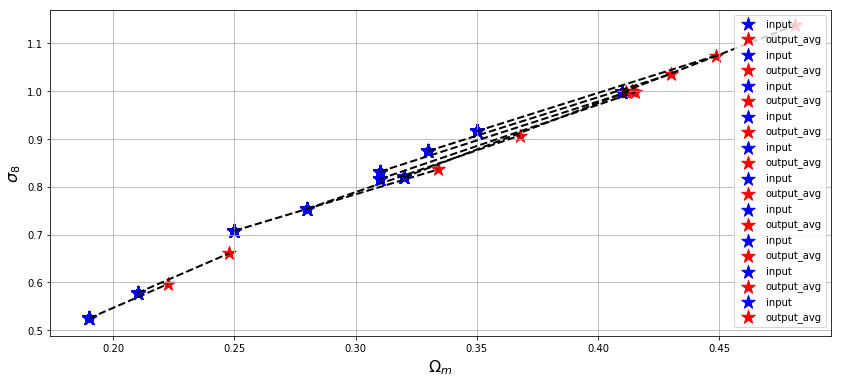

save model to : ./src/model1.1.1Llocal/10.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  10 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 525s 35s/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 2/10
15/15 [==============================] - 513s 34s/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0257 - val_mean_squared_error: 0.0257
Epoch 3/10
15/15 [==============================] - 519s 35s/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 4/10
15/15 [==============================] - 528s 35s/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 5/10
15/15 [==============================] - 527s 35s/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0

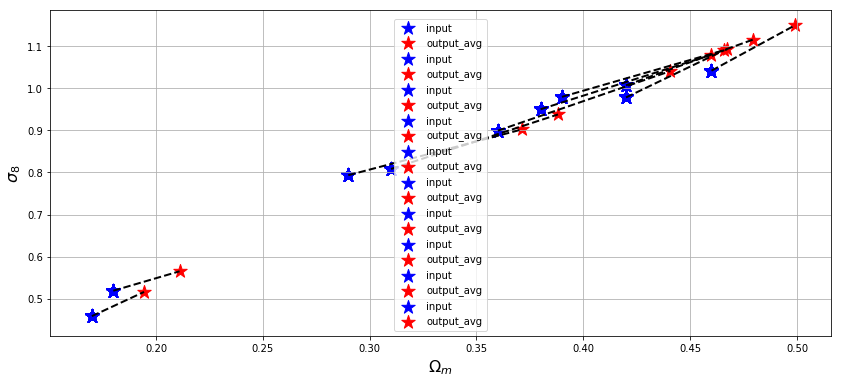

save model to : ./src/model1.1.1Llocal/20.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  20 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 542s 36s/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 2/10
15/15 [==============================] - 531s 35s/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 3/10
15/15 [==============================] - 527s 35s/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 4/10
15/15 [==============================] - 527s 35s/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 5/10
15/15 [==============================] - 529s 35s/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0

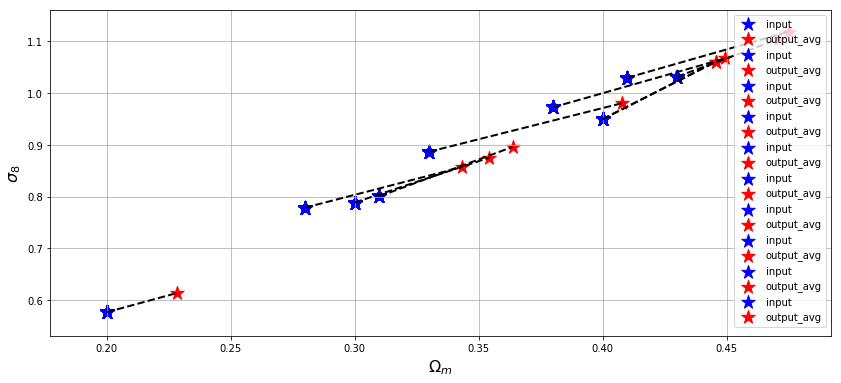

save model to : ./src/model1.1.1Llocal/30.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  30 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 537s 36s/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 2/10
15/15 [==============================] - 528s 35s/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 3/10
15/15 [==============================] - 530s 35s/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 4/10
15/15 [==============================] - 528s 35s/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 5/10
15/15 [==============================] - 529s 35s/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0

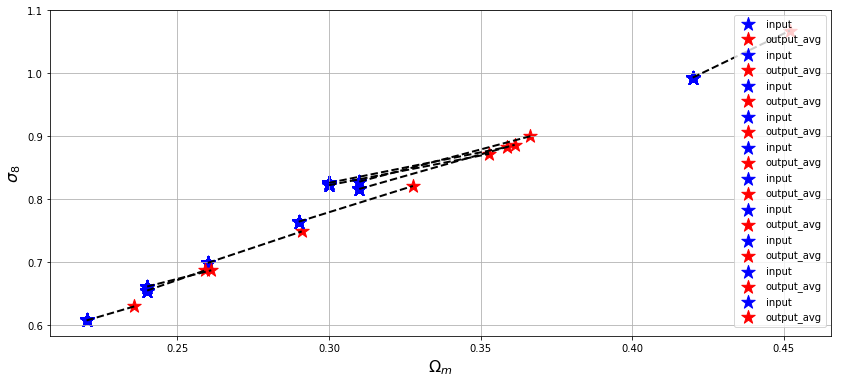

save model to : ./src/model1.1.1Llocal/40.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  40 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 534s 36s/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/10
15/15 [==============================] - 525s 35s/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 3/10
15/15 [==============================] - 524s 35s/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 4/10
15/15 [==============================] - 526s 35s/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 5/10
15/15 [==============================] - 524s 35s/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0

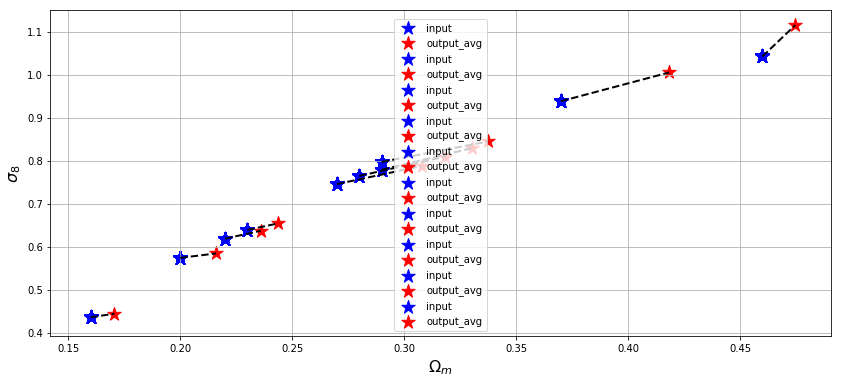

save model to : ./src/model1.1.1Llocal/50.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  50 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 532s 35s/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 2/10
15/15 [==============================] - 523s 35s/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 3/10
15/15 [==============================] - 524s 35s/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 4/10
15/15 [==============================] - 524s 35s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 5/10
15/15 [==============================] - 522s 35s/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0

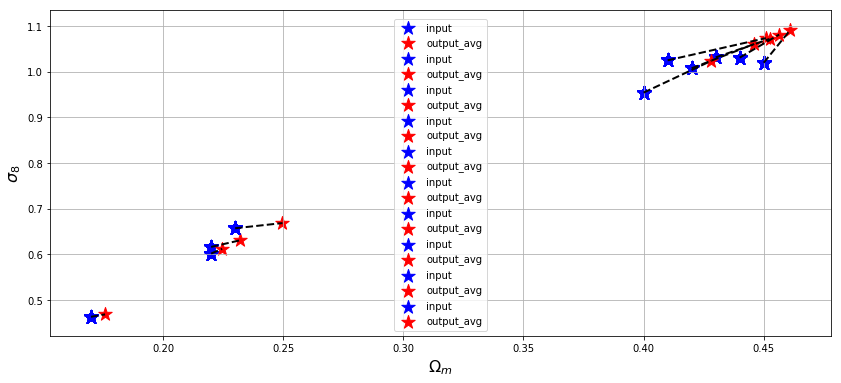

save model to : ./src/model1.1.1Llocal/60.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  60 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 531s 35s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 2/10
15/15 [==============================] - 521s 35s/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 3/10
15/15 [==============================] - 524s 35s/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 4/10
15/15 [==============================] - 524s 35s/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 5/10
15/15 [==============================] - 524s 35s/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0

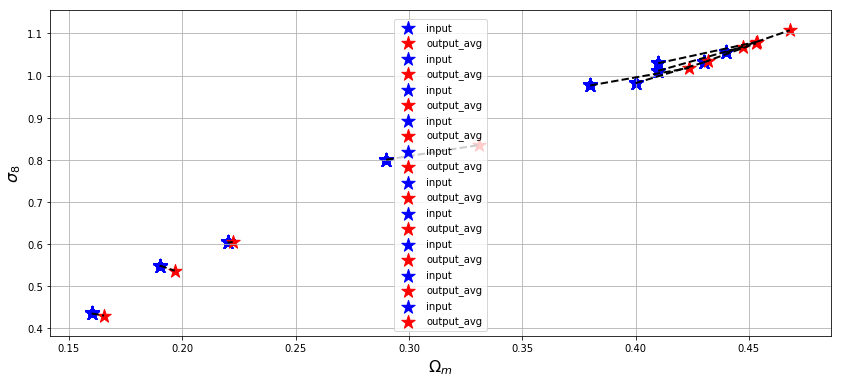

save model to : ./src/model1.1.1Llocal/70.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  70 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 533s 36s/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 2/10
15/15 [==============================] - 529s 35s/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 3/10
15/15 [==============================] - 526s 35s/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 4/10
15/15 [==============================] - 528s 35s/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 5/10
15/15 [==============================] - 526s 35s/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0

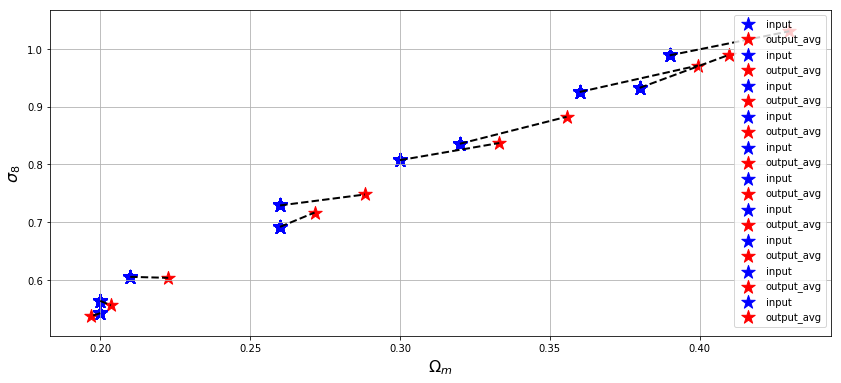

save model to : ./src/model1.1.1Llocal/80.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  80 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 537s 36s/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 9.2747e-04 - val_mean_squared_error: 9.2747e-04
Epoch 2/10
15/15 [==============================] - 525s 35s/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 9.1895e-04 - val_mean_squared_error: 9.1895e-04
Epoch 3/10
15/15 [==============================] - 531s 35s/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 6.9245e-04 - val_mean_squared_error: 6.9245e-04
Epoch 4/10
15/15 [==============================] - 526s 35s/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 8.0451e-04 - val_mean_squared_error: 8.0451e-04
Epoch 5/10
15/15 [==============================] - 528s 35s/step - loss: 0.0023 - mean_squ

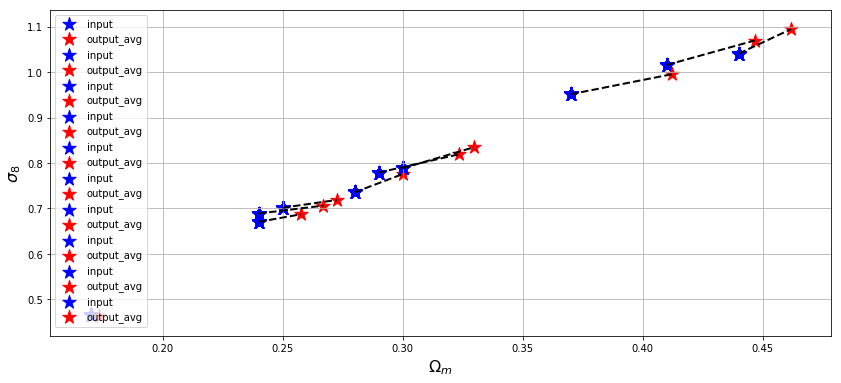

save model to : ./src/model1.1.1Llocal/90.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  90 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 537s 36s/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 1.2305e-04 - val_mean_squared_error: 1.2305e-04
Epoch 2/10
15/15 [==============================] - 527s 35s/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 1.0264e-04 - val_mean_squared_error: 1.0264e-04
Epoch 3/10
15/15 [==============================] - 527s 35s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 1.2812e-04 - val_mean_squared_error: 1.2812e-04
Epoch 4/10
15/15 [==============================] - 528s 35s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 1.0372e-04 - val_mean_squared_error: 1.0372e-04
Epoch 5/10
15/15 [==============================] - 528s 35s/step - loss: 0.0024 - mean_squ

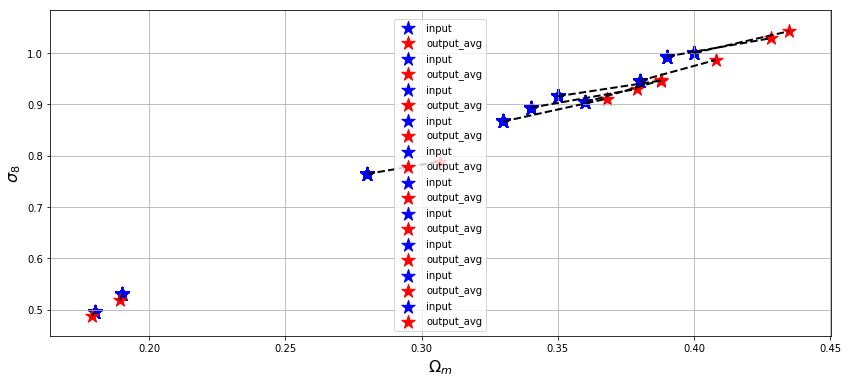

save model to : ./src/model1.1.1Llocal/100.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  100 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 532s 35s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 1.5672e-04 - val_mean_squared_error: 1.5672e-04
Epoch 2/10
15/15 [==============================] - 523s 35s/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 1.5954e-04 - val_mean_squared_error: 1.5954e-04
Epoch 3/10
15/15 [==============================] - 522s 35s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 1.6648e-04 - val_mean_squared_error: 1.6648e-04
Epoch 4/10
15/15 [==============================] - 520s 35s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 1.6467e-04 - val_mean_squared_error: 1.6467e-04
Epoch 5/10
15/15 [==============================] - 521s 35s/step - loss: 0.0022 - mean_s

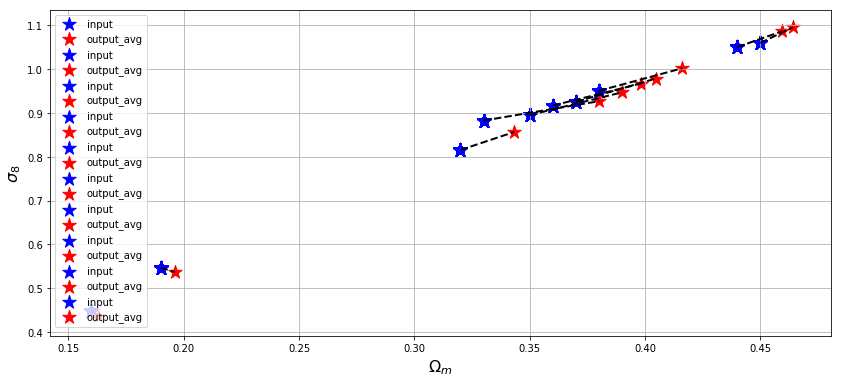

save model to : ./src/model1.1.1Llocal/110.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  110 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 535s 36s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 2/10
15/15 [==============================] - 532s 35s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 3/10
15/15 [==============================] - 529s 35s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/10
15/15 [==============================] - 526s 35s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/10
15/15 [==============================] - 531s 35s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss:

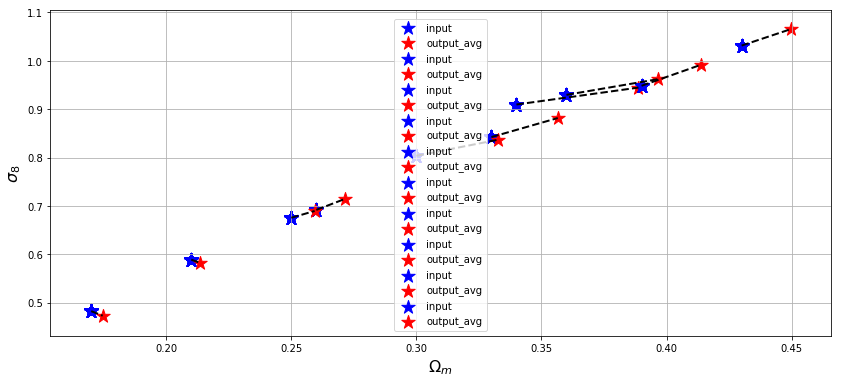

save model to : ./src/model1.1.1Llocal/120.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  120 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 538s 36s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 1.7478e-04 - val_mean_squared_error: 1.7478e-04
Epoch 2/10
15/15 [==============================] - 530s 35s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 1.8057e-04 - val_mean_squared_error: 1.8057e-04
Epoch 3/10
15/15 [==============================] - 525s 35s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 1.6938e-04 - val_mean_squared_error: 1.6938e-04
Epoch 4/10
15/15 [==============================] - 524s 35s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 1.7225e-04 - val_mean_squared_error: 1.7225e-04
Epoch 5/10
15/15 [==============================] - 522s 35s/step - loss: 0.0019 - mean_s

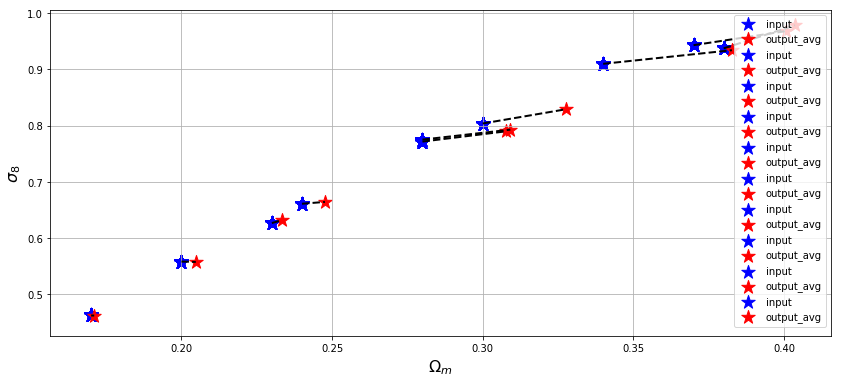

save model to : ./src/model1.1.1Llocal/130.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  130 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 526s 35s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/10
15/15 [==============================] - 519s 35s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 3/10
15/15 [==============================] - 520s 35s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/10
15/15 [==============================] - 519s 35s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 5/10
15/15 [==============================] - 523s 35s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss:

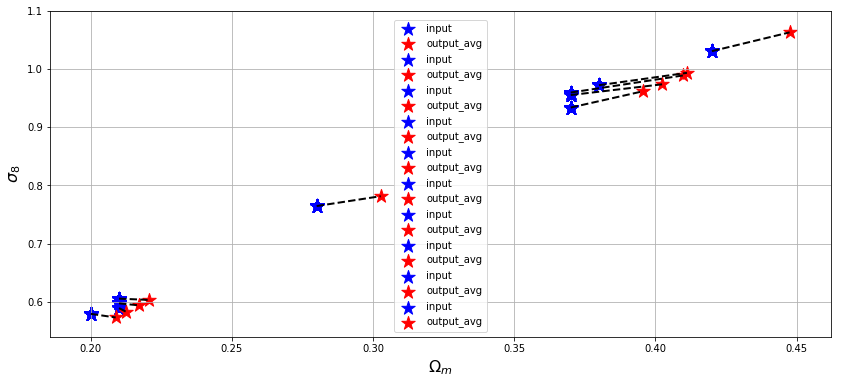

save model to : ./src/model1.1.1Llocal/140.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  140 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 532s 35s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 2.0128e-04 - val_mean_squared_error: 2.0128e-04
Epoch 2/10
15/15 [==============================] - 524s 35s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 2.0356e-04 - val_mean_squared_error: 2.0356e-04
Epoch 3/10
15/15 [==============================] - 525s 35s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 2.0978e-04 - val_mean_squared_error: 2.0978e-04
Epoch 4/10
15/15 [==============================] - 527s 35s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 1.9954e-04 - val_mean_squared_error: 1.9954e-04
Epoch 5/10
15/15 [==============================] - 525s 35s/step - loss: 0.0020 - mean_s

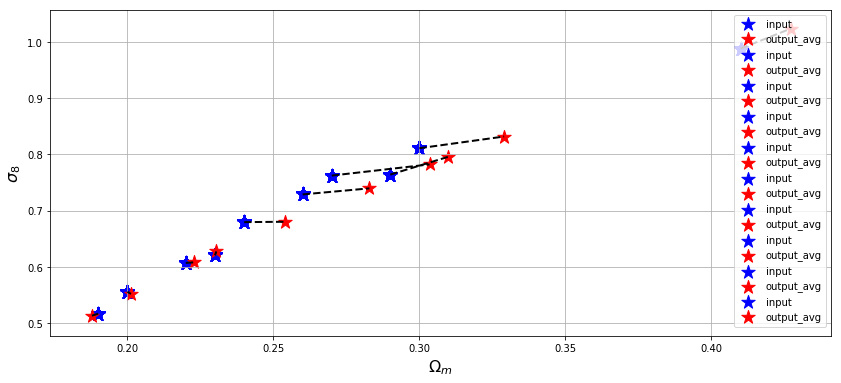

save model to : ./src/model1.1.1Llocal/150.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  150 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 536s 36s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 2.1881e-04 - val_mean_squared_error: 2.1881e-04
Epoch 2/10
15/15 [==============================] - 561s 37s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 2.1218e-04 - val_mean_squared_error: 2.1218e-04
Epoch 3/10
15/15 [==============================] - 532s 35s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 2.3820e-04 - val_mean_squared_error: 2.3820e-04
Epoch 4/10
15/15 [==============================] - 521s 35s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 2.6832e-04 - val_mean_squared_error: 2.6832e-04
Epoch 5/10
15/15 [==============================] - 521s 35s/step - loss: 0.0020 - mean_s

In [ ]:
epochs = 0 

step_epoch = 10

while epochs <= max_epochs:

    print('###############################################')
    print('Begin training for '+modelname+', current epochs = ', epochs, '; max_epochs = ', max_epochs, '...')
    print('###############################################')
    outputf.write('###############################################\n')
    outputf.write('Begin training for '+modelname+', current epochs = '+ str(epochs)+ '; max_epochs = '+str( max_epochs)+ '...\n')
    outputf.write('###############################################\n')

    if True:
        nowmodel.fit_generator(train_generator(),
                    steps_per_epoch=465//batch_size,  # 数据规格可能大小不对应
                    epochs=step_epoch,
                    verbose=1,
                    validation_data=(x_test,y_test))
    epochs += step_epoch

    filepath = './'+modelname+'/'+str(epochs)+'.save'
    # Plot validation
    if True:
        fig, ax = None, None
        for row in range(10):
            x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
            fig, ax = plot_test(nowmodel, x_test, y_test, fig=fig, ax=ax)
        ax.grid(); plt.show()
        ax.set_title('#-epochs = '+str(epochs), fontsize=16)
        fig.savefig(filepath+'.png', format='png')
    print('save model to :', filepath )
    outputf.write('save model to :'+str(filepath)+ '\n')
    keras.models.save_model(nowmodel, filepath)

outputf.close()


In [8]:
!ls

DE
dt1.png
generator_test.ipynb
gitpush.sh
haha
keras_1_intro.ipynb
keras_1.ipynb
keras_2_mnist_cnn.ipynb
keras_3_rnn.ipynb
kmeans1.png
kmeans2.png
kmeans3.png
knn_files
logs
lsslearn_1(fit_generator).ipynb
lsslearn_1(fit_generator_optimization).ipynb
lsslearn_1(fit_generator_optimization_xiaodongtest)(1).py
lsslearn_1(fit_generator_optimization_xiaodongtest).ipynb
lsslearn_1_fit_generator_optimization_xiaodongtest.py
lsslearn_1.ipynb
lsslearn_1(rewrited)_2.ipynb
lsslearn_1(rewrited).ipynb
lsslearn_2_test_epochs.ipynb
meanshift1.png
meanshift2.png
ml_map.png
model1.h5
model1_old
NB1.png
om_As
Papers
README
regress_ximu.ipynb
rsync.sh
sklearn_1.ipynb
sklearn_2_验证.ipynb
sklearn_3_分类_DecisionTree_RandomForest_SVM_NBC_LR.ipynb
sklearn_4_分类_随机森林.ipynb
sklearn_4_回归_.ipynb
sklearn_5_聚类.ipynb
sklearn_6_聚类_其他算法.ipynb
sklearn_7_降维.ipynb
sklearn_正则化.ipynb
src
svr1.jpg
svr2.jpg
th.jpeg
Untitled1.ipynb
Untitled2.ipynb
Untitled3.ipynb
Untitled4.ipynb
Untitled5.ipynb
Untitled6.ipynb
Untitled.ipynb
分类

#### interuptted due to power;... resume...

###############################################
Begin training for src/model1.1.1Llocal, current epochs =  150 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 516s 34s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0733 - val_mean_squared_error: 0.0733
Epoch 2/10
15/15 [==============================] - 510s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0740 - val_mean_squared_error: 0.0740
Epoch 3/10
15/15 [==============================] - 508s 34s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0744 - val_mean_squared_error: 0.0744
Epoch 4/10
15/15 [==============================] - 506s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0751 - val_mean_squared_error: 0.0751
Epoch 5/10
15/15 [==============================] - 508s 34s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0715 - val_mean_squared_error: 0.0715
Epoch 6

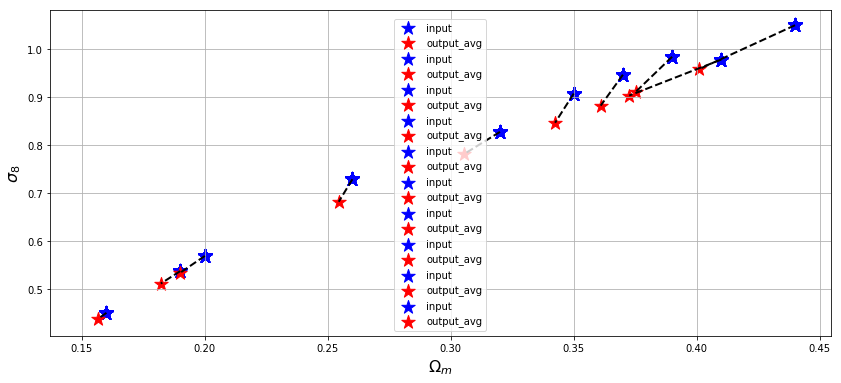

save model to : ./src/model1.1.1Llocal/160.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  160 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 515s 34s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 2/10
15/15 [==============================] - 503s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 3/10
15/15 [==============================] - 510s 34s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 4/10
15/15 [==============================] - 506s 34s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 5/10
15/15 [==============================] - 507s 34s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss:

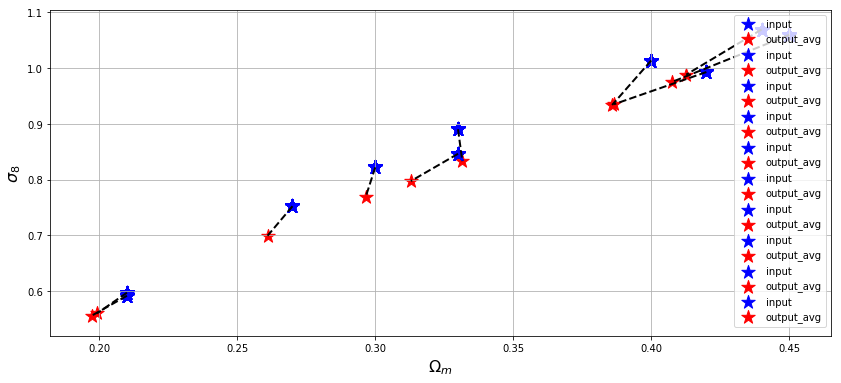

save model to : ./src/model1.1.1Llocal/170.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  170 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 513s 34s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/10
15/15 [==============================] - 505s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 3/10
15/15 [==============================] - 506s 34s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 4/10
15/15 [==============================] - 504s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/10
15/15 [==============================] - 508s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss:

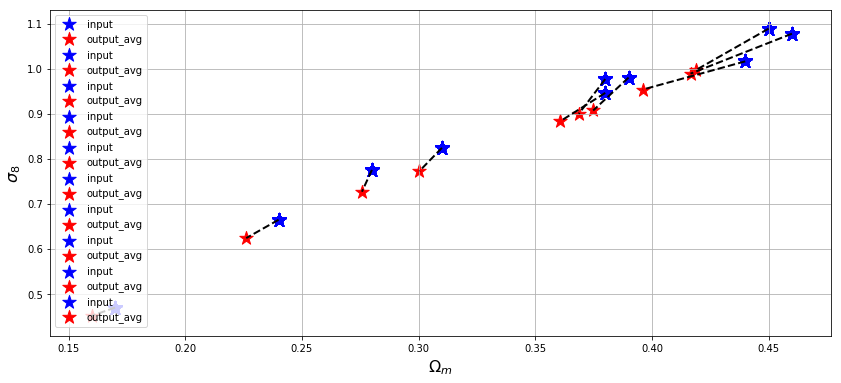

save model to : ./src/model1.1.1Llocal/180.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  180 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 517s 34s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.7760e-04 - val_mean_squared_error: 3.7760e-04
Epoch 2/10
15/15 [==============================] - 508s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 3.0112e-04 - val_mean_squared_error: 3.0112e-04
Epoch 3/10
15/15 [==============================] - 507s 34s/step - loss: 8.7393e-04 - mean_squared_error: 8.7393e-04 - val_loss: 2.0385e-04 - val_mean_squared_error: 2.0385e-04
Epoch 4/10
15/15 [==============================] - 508s 34s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.0454e-04 - val_mean_squared_error: 3.0454e-04
Epoch 5/10
15/15 [==============================] - 507s 34s/step - loss: 0.0010 

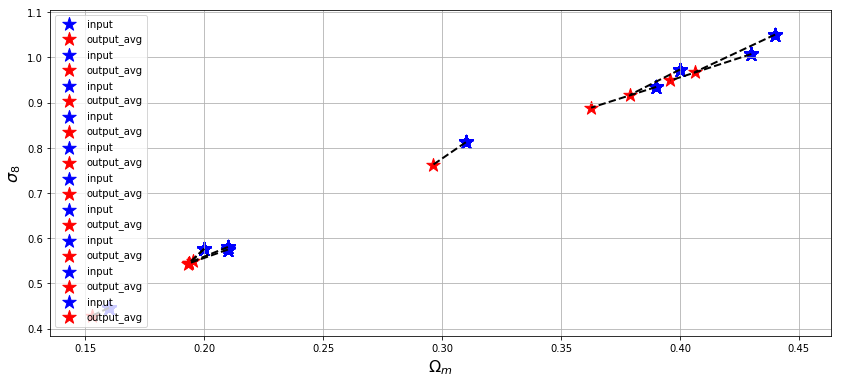

save model to : ./src/model1.1.1Llocal/190.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  190 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 516s 34s/step - loss: 9.9189e-04 - mean_squared_error: 9.9189e-04 - val_loss: 6.0007e-04 - val_mean_squared_error: 6.0007e-04
Epoch 2/10
15/15 [==============================] - 512s 34s/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 7.1704e-04 - val_mean_squared_error: 7.1704e-04
Epoch 3/10
15/15 [==============================] - 506s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 6.4823e-04 - val_mean_squared_error: 6.4823e-04
Epoch 4/10
15/15 [==============================] - 505s 34s/step - loss: 9.1922e-04 - mean_squared_error: 9.1922e-04 - val_loss: 6.0249e-04 - val_mean_squared_error: 6.0249e-04
Epoch 5/10
15/15 [==============================] - 509s 34s/step - loss:

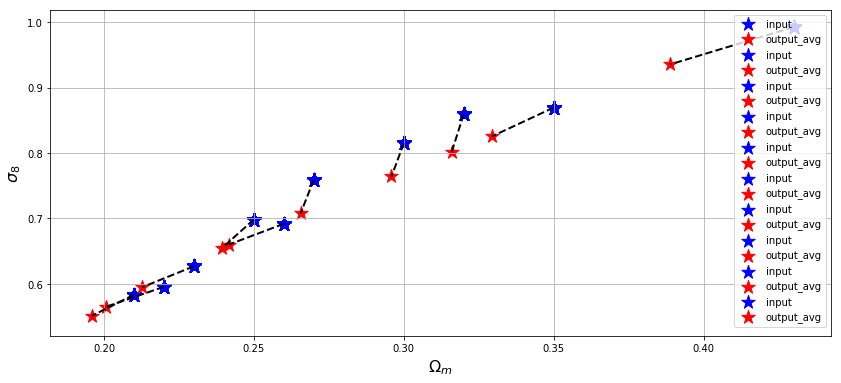

save model to : ./src/model1.1.1Llocal/200.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  200 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 514s 34s/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.5999e-04 - val_mean_squared_error: 9.5999e-04
Epoch 2/10
15/15 [==============================] - 507s 34s/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.9492e-04 - val_mean_squared_error: 9.9492e-04
Epoch 3/10
15/15 [==============================] - 508s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/10
15/15 [==============================] - 504s 34s/step - loss: 9.7023e-04 - mean_squared_error: 9.7023e-04 - val_loss: 9.8125e-04 - val_mean_squared_error: 9.8125e-04
Epoch 5/10
15/15 [==============================] - 503s 34s/step - loss: 0.0010 - mean_s

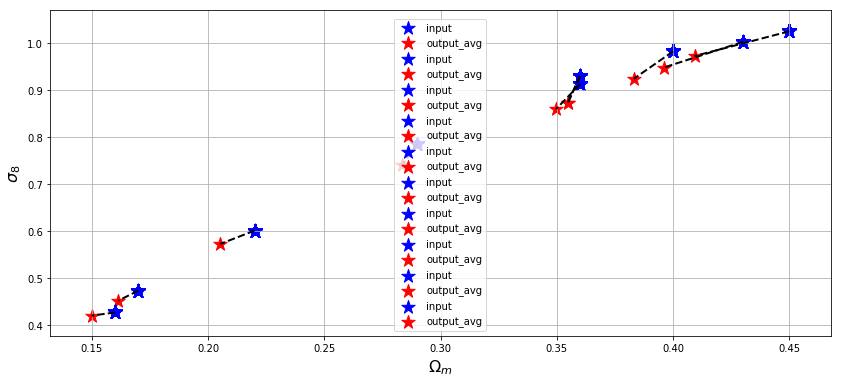

save model to : ./src/model1.1.1Llocal/210.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  210 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 513s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 2/10
15/15 [==============================] - 505s 34s/step - loss: 8.0168e-04 - mean_squared_error: 8.0168e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 3/10
15/15 [==============================] - 508s 34s/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/10
15/15 [==============================] - 506s 34s/step - loss: 9.5934e-04 - mean_squared_error: 9.5934e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/10
15/15 [==============================] - 505s 34s/step - loss: 9.8698e-04 - mean_squared_error

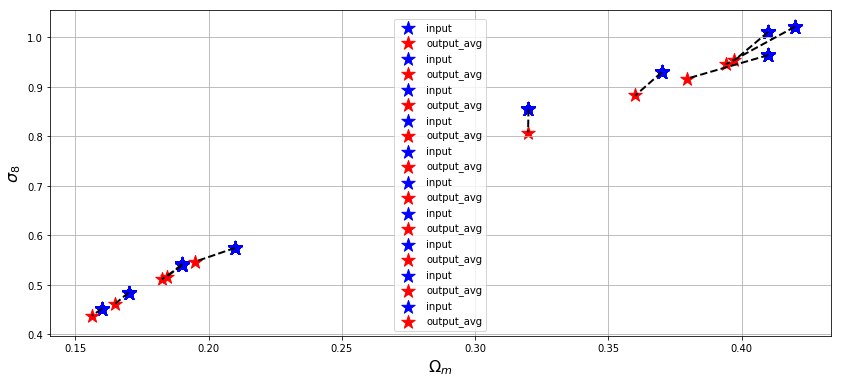

save model to : ./src/model1.1.1Llocal/220.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  220 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 512s 34s/step - loss: 9.0987e-04 - mean_squared_error: 9.0987e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 2/10
15/15 [==============================] - 506s 34s/step - loss: 9.8779e-04 - mean_squared_error: 9.8779e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 3/10
15/15 [==============================] - 506s 34s/step - loss: 9.3593e-04 - mean_squared_error: 9.3593e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 4/10
15/15 [==============================] - 506s 34s/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/10
15/15 [==============================] - 506s 34s/step - loss: 0.0010 - mean_squared_e

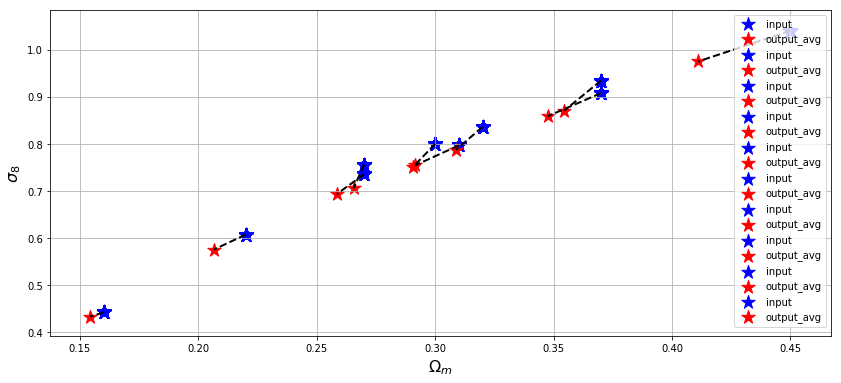

save model to : ./src/model1.1.1Llocal/230.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  230 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 516s 34s/step - loss: 9.3093e-04 - mean_squared_error: 9.3093e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 2/10
15/15 [==============================] - 505s 34s/step - loss: 9.3969e-04 - mean_squared_error: 9.3969e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/10
15/15 [==============================] - 505s 34s/step - loss: 9.8131e-04 - mean_squared_error: 9.8131e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/10
15/15 [==============================] - 504s 34s/step - loss: 9.4398e-04 - mean_squared_error: 9.4398e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/10
15/15 [==============================] - 504s 34s/step - loss: 8.7009e-04 - me

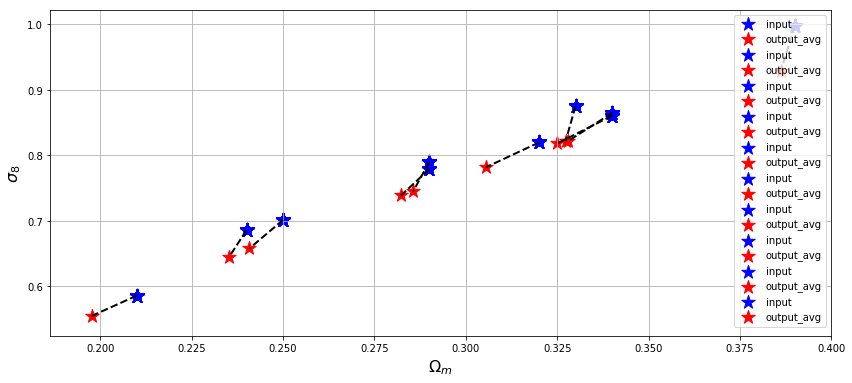

save model to : ./src/model1.1.1Llocal/240.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  240 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 515s 34s/step - loss: 8.1394e-04 - mean_squared_error: 8.1394e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 2/10
15/15 [==============================] - 505s 34s/step - loss: 9.6764e-04 - mean_squared_error: 9.6764e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 3/10
15/15 [==============================] - 504s 34s/step - loss: 8.0442e-04 - mean_squared_error: 8.0442e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/10
15/15 [==============================] - 505s 34s/step - loss: 8.7250e-04 - mean_squared_error: 8.7250e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 5/10
15/15 [==============================] - 506s 34s/step - loss: 8.2959e-04 - me

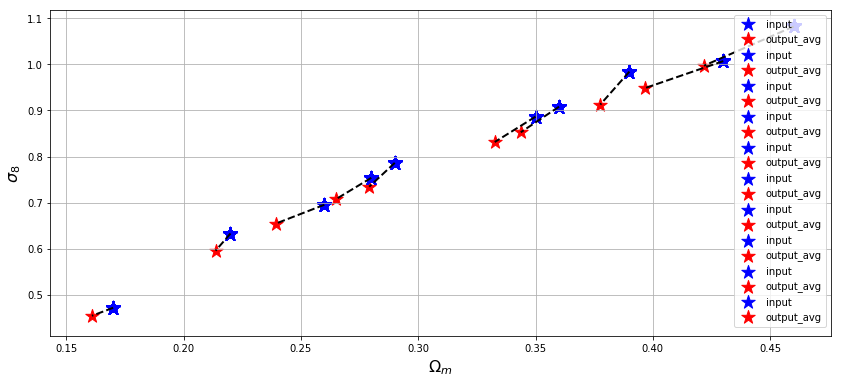

save model to : ./src/model1.1.1Llocal/250.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  250 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 510s 34s/step - loss: 9.1341e-04 - mean_squared_error: 9.1341e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 2/10
15/15 [==============================] - 501s 33s/step - loss: 8.6045e-04 - mean_squared_error: 8.6045e-04 - val_loss: 8.7977e-04 - val_mean_squared_error: 8.7977e-04
Epoch 3/10
15/15 [==============================] - 501s 33s/step - loss: 7.8080e-04 - mean_squared_error: 7.8080e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/10
15/15 [==============================] - 498s 33s/step - loss: 9.0878e-04 - mean_squared_error: 9.0878e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 5/10
15/15 [==============================] - 497s 33s/step - loss: 8.8958e

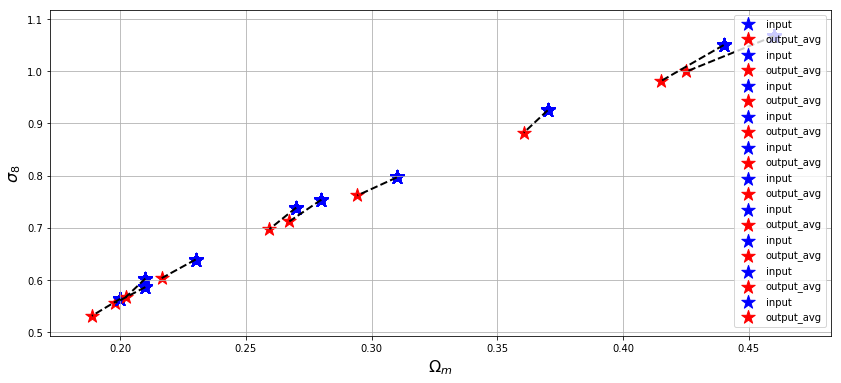

save model to : ./src/model1.1.1Llocal/260.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  260 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 519s 35s/step - loss: 7.7841e-04 - mean_squared_error: 7.7841e-04 - val_loss: 6.7234e-04 - val_mean_squared_error: 6.7234e-04
Epoch 2/10
15/15 [==============================] - 515s 34s/step - loss: 8.5045e-04 - mean_squared_error: 8.5045e-04 - val_loss: 6.6379e-04 - val_mean_squared_error: 6.6379e-04
Epoch 3/10
15/15 [==============================] - 517s 34s/step - loss: 8.8395e-04 - mean_squared_error: 8.8395e-04 - val_loss: 7.3530e-04 - val_mean_squared_error: 7.3530e-04
Epoch 4/10
15/15 [==============================] - 514s 34s/step - loss: 7.4096e-04 - mean_squared_error: 7.4096e-04 - val_loss: 6.8643e-04 - val_mean_squared_error: 6.8643e-04
Epoch 5/10
15/15 [==============================] - 536s 

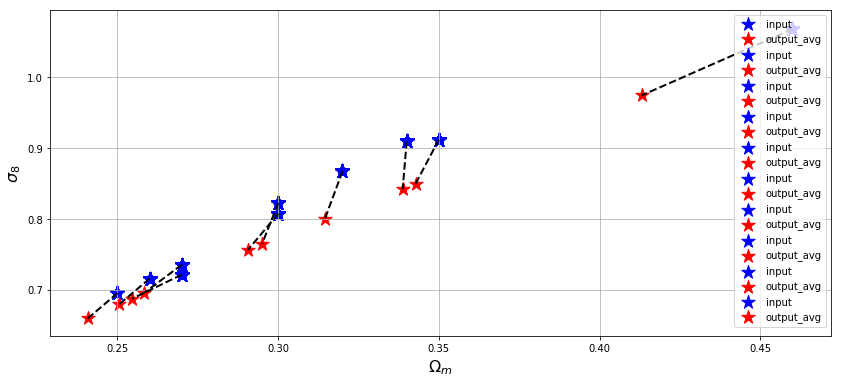

save model to : ./src/model1.1.1Llocal/270.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  270 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 510s 34s/step - loss: 7.5564e-04 - mean_squared_error: 7.5564e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 2/10
15/15 [==============================] - 503s 34s/step - loss: 7.9477e-04 - mean_squared_error: 7.9477e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 3/10
15/15 [==============================] - 500s 33s/step - loss: 8.3903e-04 - mean_squared_error: 8.3903e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/10
15/15 [==============================] - 501s 33s/step - loss: 7.5141e-04 - mean_squared_error: 7.5141e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/10
15/15 [==============================] - 505s 34s/step - loss: 7.3520e-04 - me

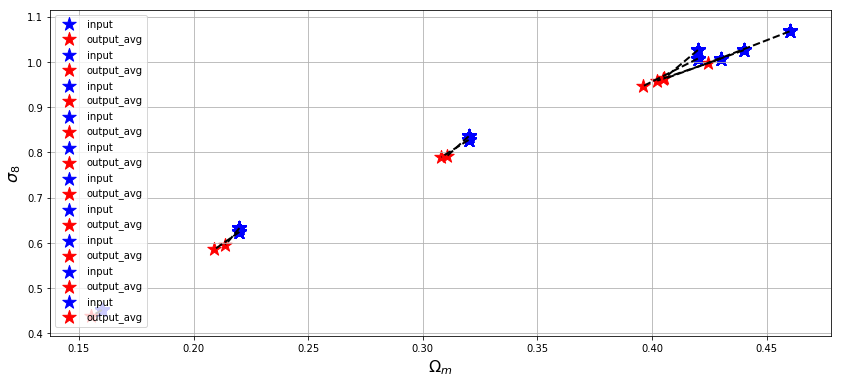

save model to : ./src/model1.1.1Llocal/280.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  280 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 524s 35s/step - loss: 7.2574e-04 - mean_squared_error: 7.2574e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 2/10
15/15 [==============================] - 513s 34s/step - loss: 8.2431e-04 - mean_squared_error: 8.2431e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/10
 9/15 [=================>............] - ETA: 3:26 - loss: 8.4167e-04 - mean_squared_error: 8.4167e-04

KeyboardInterrupt: 

In [10]:
epochs = 150

nowmodel = keras.models.load_model('/home/xiaodongli/projects/AI/src/model1.1.1Llocal/150.save')

step_epoch = 10

while epochs <= max_epochs:

    print('###############################################')
    print('Begin training for '+modelname+', current epochs = ', epochs, '; max_epochs = ', max_epochs, '...')
    print('###############################################')
    outputf.write('###############################################\n')
    outputf.write('Begin training for '+modelname+', current epochs = '+ str(epochs)+ '; max_epochs = '+str( max_epochs)+ '...\n')
    outputf.write('###############################################\n')

    if True:
        nowmodel.fit_generator(train_generator(),
                    steps_per_epoch=465//batch_size,  # 数据规格可能大小不对应
                    epochs=step_epoch,
                    verbose=1,
                    validation_data=(x_test,y_test))
    epochs += step_epoch

    filepath = './'+modelname+'/'+str(epochs)+'.save'
    # Plot validation
    if True:
        fig, ax = None, None
        for row in range(10):
            x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
            fig, ax = plot_test(nowmodel, x_test, y_test, fig=fig, ax=ax)
        ax.grid(); plt.show()
        ax.set_title('#-epochs = '+str(epochs), fontsize=16)
        fig.savefig(filepath+'.png', format='png')
    print('save model to :', filepath )
    outputf.write('save model to :'+str(filepath)+ '\n')
    keras.models.save_model(nowmodel, filepath)

outputf.close()


Instructions for updating:
Use tf.cast instead.
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  280 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 530s 35s/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0918 - val_mean_squared_error: 0.0918
Epoch 2/10
15/15 [==============================] - 530s 35s/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0916 - val_mean_squared_error: 0.0916
Epoch 3/10
15/15 [==============================] - 528s 35s/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0926 - val_mean_squared_error: 0.0926
Epoch 4/10
15/15 [==============================] - 528s 35s/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0930 - val_mean_squared_error: 0.0930
Epoch 5/10
15/15 [==============================] - 527s 35s/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss:

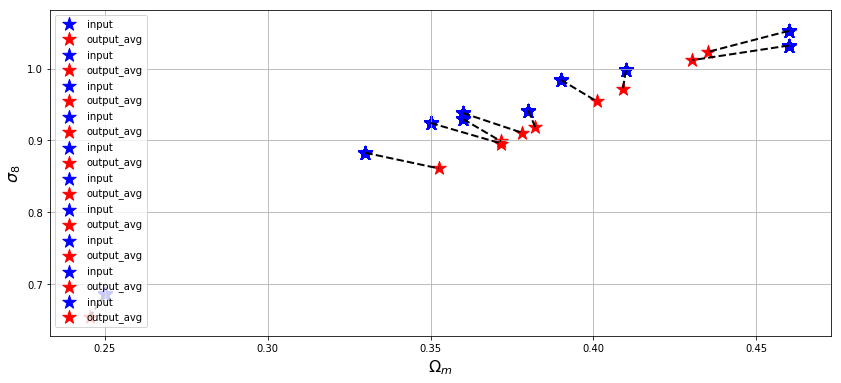

save model to : ./src/model1.1.1Llocal/290.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  290 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 541s 36s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 8.3650e-04 - val_mean_squared_error: 8.3650e-04
Epoch 2/10
15/15 [==============================] - 525s 35s/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 8.2503e-04 - val_mean_squared_error: 8.2503e-04
Epoch 3/10
15/15 [==============================] - 521s 35s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 7.9556e-04 - val_mean_squared_error: 7.9556e-04
Epoch 4/10
15/15 [==============================] - 508s 34s/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/10
15/15 [==============================] - 507s 34s/step - loss: 0.0021 - mean_squared_e

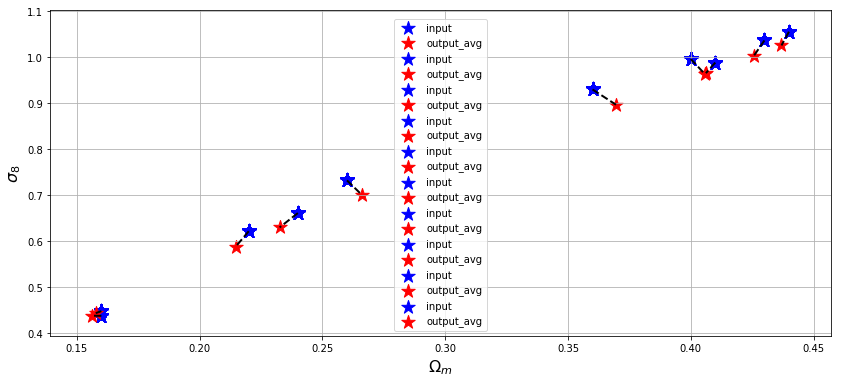

save model to : ./src/model1.1.1Llocal/300.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  300 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 522s 35s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 8.2788e-04 - val_mean_squared_error: 8.2788e-04
Epoch 2/10
15/15 [==============================] - 511s 34s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/10
15/15 [==============================] - 522s 35s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 9.5514e-04 - val_mean_squared_error: 9.5514e-04
Epoch 4/10
15/15 [==============================] - 522s 35s/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 9.7139e-04 - val_mean_squared_error: 9.7139e-04
Epoch 5/10
15/15 [==============================] - 524s 35s/step - loss: 0.0020 - mean_squared_e

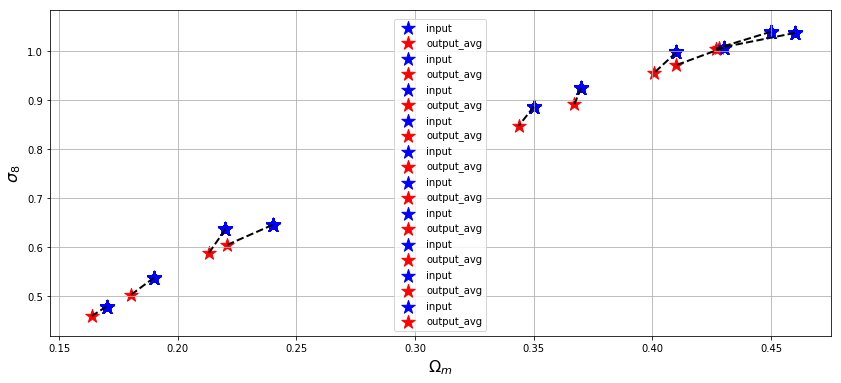

save model to : ./src/model1.1.1Llocal/310.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  310 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 534s 36s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/10
15/15 [==============================] - 519s 35s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/10
15/15 [==============================] - 522s 35s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/10
15/15 [==============================] - 523s 35s/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/10
15/15 [==============================] - 520s 35s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss:

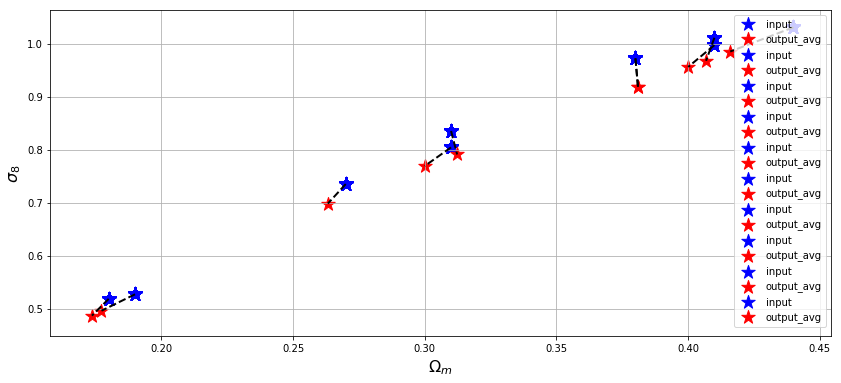

save model to : ./src/model1.1.1Llocal/320.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  320 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 531s 35s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/10
15/15 [==============================] - 517s 34s/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 3/10
15/15 [==============================] - 520s 35s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/10
15/15 [==============================] - 520s 35s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/10
15/15 [==============================] - 516s 34s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss:

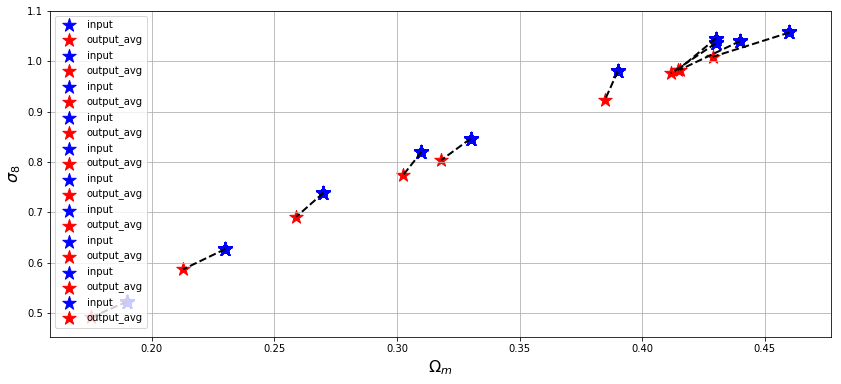

save model to : ./src/model1.1.1Llocal/330.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  330 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 527s 35s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 2/10
15/15 [==============================] - 515s 34s/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 3/10
15/15 [==============================] - 515s 34s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 4/10
15/15 [==============================] - 518s 35s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 5/10
15/15 [==============================] - 513s 34s/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss:

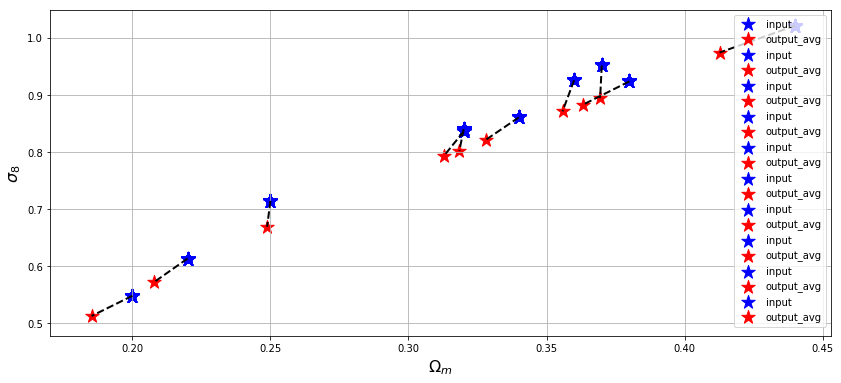

save model to : ./src/model1.1.1Llocal/340.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  340 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 530s 35s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 8.0457e-04 - val_mean_squared_error: 8.0457e-04
Epoch 2/10
15/15 [==============================] - 519s 35s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 8.0502e-04 - val_mean_squared_error: 8.0502e-04
Epoch 3/10
15/15 [==============================] - 516s 34s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 8.1954e-04 - val_mean_squared_error: 8.1954e-04
Epoch 4/10
15/15 [==============================] - 519s 35s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.8480e-04 - val_mean_squared_error: 7.8480e-04
Epoch 5/10
15/15 [==============================] - 516s 34s/step - loss: 0.0012 - mean_s

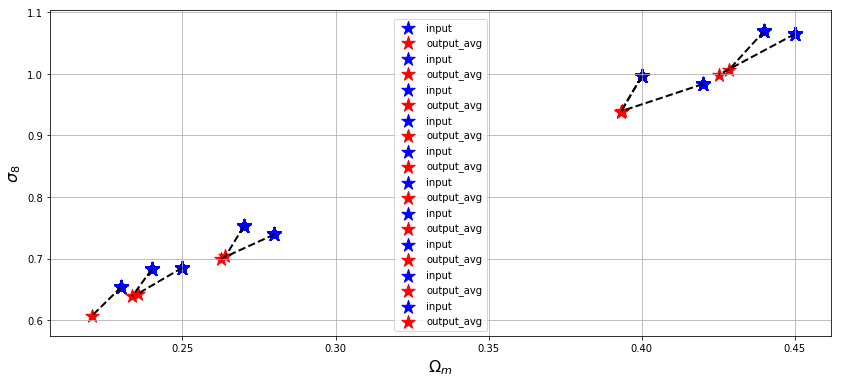

save model to : ./src/model1.1.1Llocal/350.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  350 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 531s 35s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 2/10
15/15 [==============================] - 517s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 3/10
15/15 [==============================] - 519s 35s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 4/10
15/15 [==============================] - 517s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 5/10
15/15 [==============================] - 517s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss:

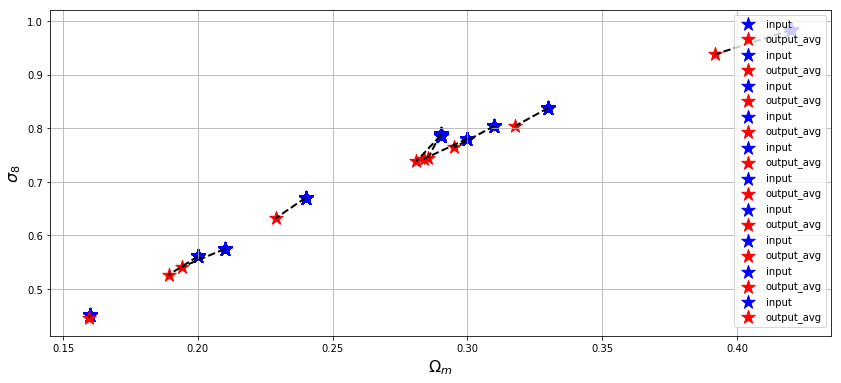

save model to : ./src/model1.1.1Llocal/360.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  360 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 531s 35s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/10
15/15 [==============================] - 518s 35s/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 3/10
15/15 [==============================] - 519s 35s/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 4/10
15/15 [==============================] - 517s 34s/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/10
15/15 [==============================] - 516s 34s/step - loss: 9.8386e-04 - mean_squared_error: 9.8386e-04 - v

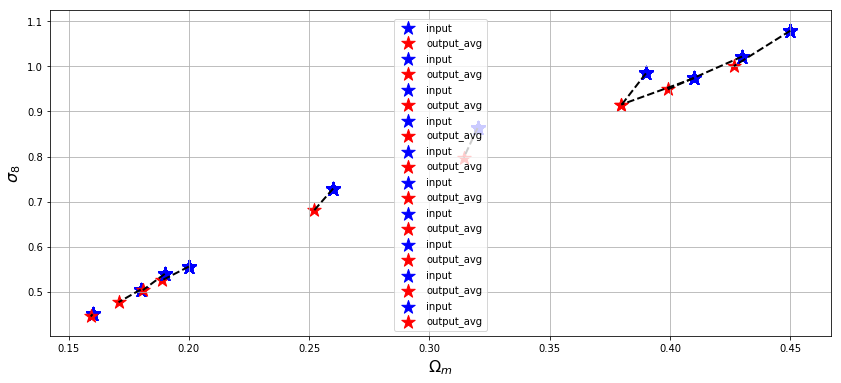

save model to : ./src/model1.1.1Llocal/370.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  370 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 532s 35s/step - loss: 7.8990e-04 - mean_squared_error: 7.8990e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 2/10
15/15 [==============================] - 517s 34s/step - loss: 9.8701e-04 - mean_squared_error: 9.8701e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 3/10
15/15 [==============================] - 521s 35s/step - loss: 9.4708e-04 - mean_squared_error: 9.4708e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 4/10
15/15 [==============================] - 520s 35s/step - loss: 8.5819e-04 - mean_squared_error: 8.5819e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/10
15/15 [==============================] - 519s 35s/step - loss: 8.6756e-04 - me

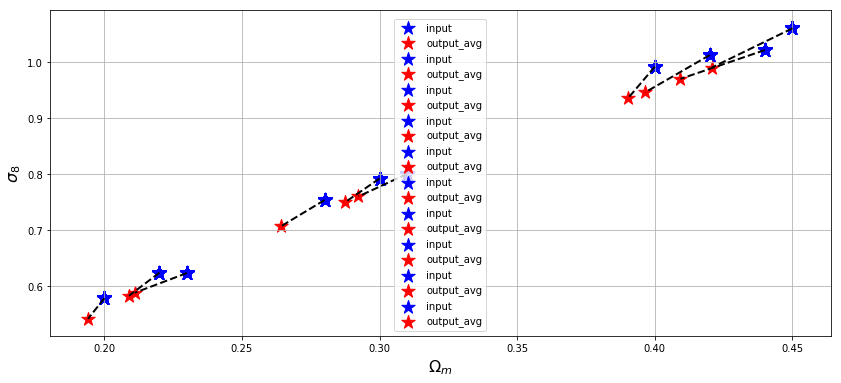

save model to : ./src/model1.1.1Llocal/380.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  380 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 530s 35s/step - loss: 9.5206e-04 - mean_squared_error: 9.5206e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 2/10
15/15 [==============================] - 516s 34s/step - loss: 9.4662e-04 - mean_squared_error: 9.4662e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 3/10
15/15 [==============================] - 517s 34s/step - loss: 8.7098e-04 - mean_squared_error: 8.7098e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/10
15/15 [==============================] - 516s 34s/step - loss: 9.2569e-04 - mean_squared_error: 9.2569e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 5/10
15/15 [==============================] - 517s 34s/step - loss: 8.6011e-04 - me

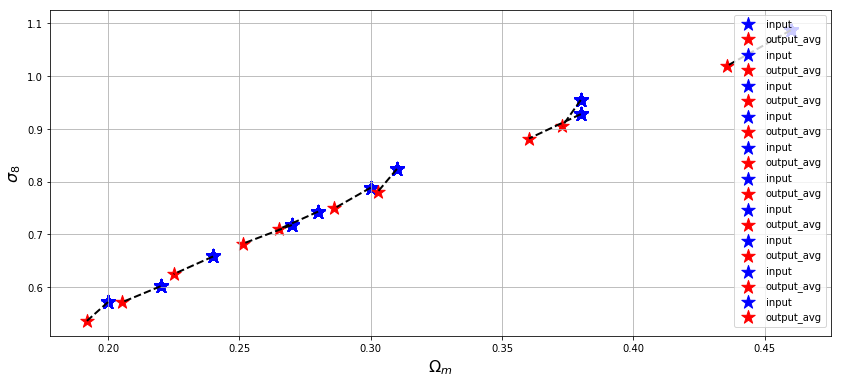

save model to : ./src/model1.1.1Llocal/390.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  390 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 529s 35s/step - loss: 8.8735e-04 - mean_squared_error: 8.8735e-04 - val_loss: 8.1883e-04 - val_mean_squared_error: 8.1883e-04
Epoch 2/10
15/15 [==============================] - 519s 35s/step - loss: 8.2376e-04 - mean_squared_error: 8.2376e-04 - val_loss: 7.1054e-04 - val_mean_squared_error: 7.1054e-04
Epoch 3/10
15/15 [==============================] - 518s 35s/step - loss: 8.1200e-04 - mean_squared_error: 8.1200e-04 - val_loss: 7.9189e-04 - val_mean_squared_error: 7.9189e-04
Epoch 4/10
15/15 [==============================] - 516s 34s/step - loss: 8.2759e-04 - mean_squared_error: 8.2759e-04 - val_loss: 7.6535e-04 - val_mean_squared_error: 7.6535e-04
Epoch 5/10
15/15 [==============================] - 518s 

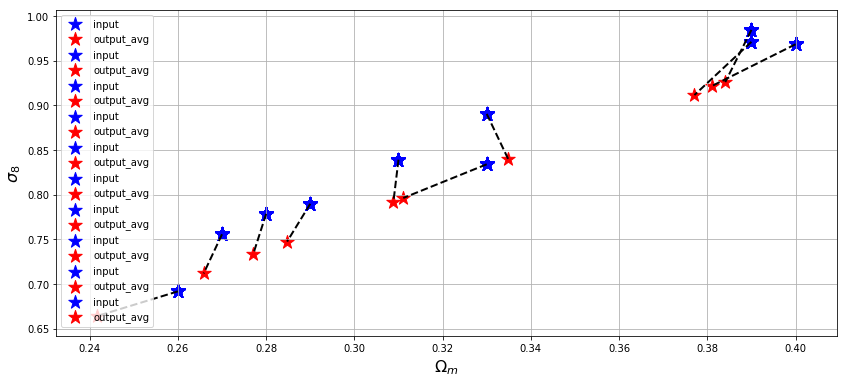

save model to : ./src/model1.1.1Llocal/400.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  400 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 531s 35s/step - loss: 7.8607e-04 - mean_squared_error: 7.8607e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/10
15/15 [==============================] - 513s 34s/step - loss: 7.8803e-04 - mean_squared_error: 7.8803e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/10
15/15 [==============================] - 515s 34s/step - loss: 8.4954e-04 - mean_squared_error: 8.4954e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/10
15/15 [==============================] - 515s 34s/step - loss: 8.0595e-04 - mean_squared_error: 8.0595e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/10
15/15 [==============================] - 516s 34s/step - loss: 7.8604e-04 - me

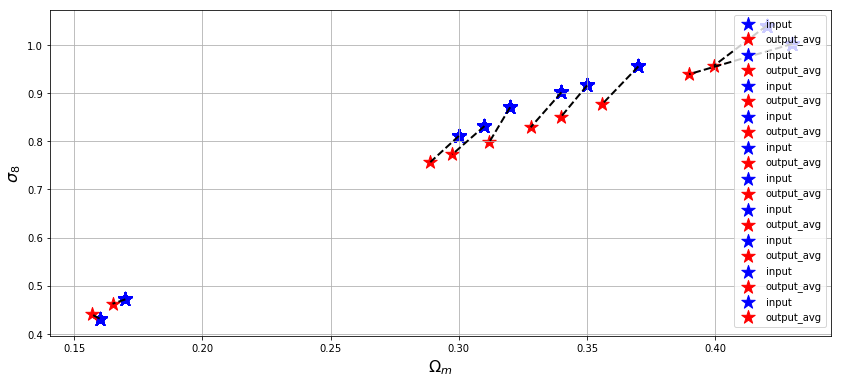

save model to : ./src/model1.1.1Llocal/410.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  410 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 524s 35s/step - loss: 8.2660e-04 - mean_squared_error: 8.2660e-04 - val_loss: 8.2764e-05 - val_mean_squared_error: 8.2764e-05
Epoch 2/10
15/15 [==============================] - 512s 34s/step - loss: 7.5202e-04 - mean_squared_error: 7.5202e-04 - val_loss: 6.4332e-05 - val_mean_squared_error: 6.4332e-05
Epoch 3/10
15/15 [==============================] - 514s 34s/step - loss: 8.7255e-04 - mean_squared_error: 8.7255e-04 - val_loss: 7.8008e-05 - val_mean_squared_error: 7.8008e-05
Epoch 4/10
15/15 [==============================] - 512s 34s/step - loss: 8.4116e-04 - mean_squared_error: 8.4116e-04 - val_loss: 6.4647e-05 - val_mean_squared_error: 6.4647e-05
Epoch 5/10
15/15 [==============================] - 514s 

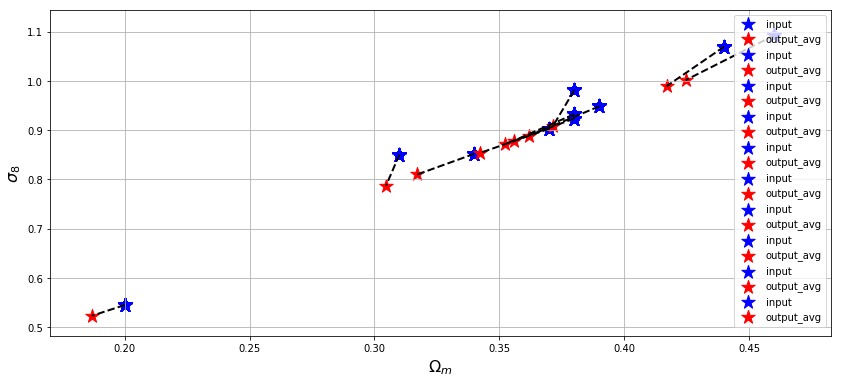

save model to : ./src/model1.1.1Llocal/420.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  420 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 525s 35s/step - loss: 7.0856e-04 - mean_squared_error: 7.0856e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 2/10
15/15 [==============================] - 512s 34s/step - loss: 6.0845e-04 - mean_squared_error: 6.0845e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 3/10
15/15 [==============================] - 508s 34s/step - loss: 8.1598e-04 - mean_squared_error: 8.1598e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/10
15/15 [==============================] - 512s 34s/step - loss: 7.5355e-04 - mean_squared_error: 7.5355e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 5/10
15/15 [==============================] - 511s 34s/step - loss: 7.4621e-04 - me

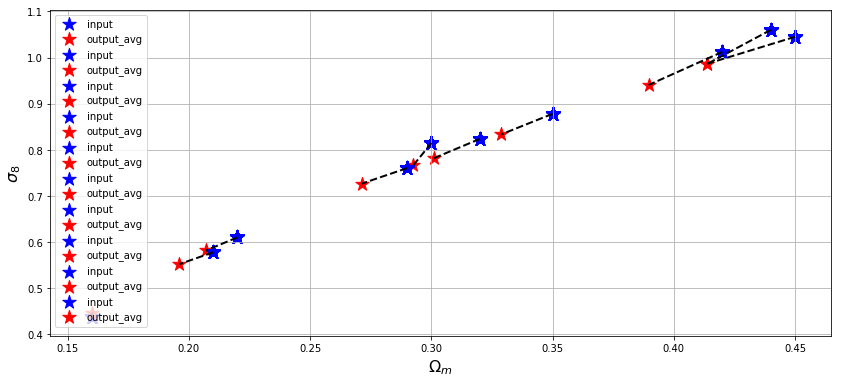

save model to : ./src/model1.1.1Llocal/430.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  430 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 523s 35s/step - loss: 8.0884e-04 - mean_squared_error: 8.0884e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2/10
15/15 [==============================] - 511s 34s/step - loss: 6.6762e-04 - mean_squared_error: 6.6762e-04 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 3/10
15/15 [==============================] - 511s 34s/step - loss: 6.3090e-04 - mean_squared_error: 6.3090e-04 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 4/10
15/15 [==============================] - 513s 34s/step - loss: 7.1238e-04 - mean_squared_error: 7.1238e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/10
15/15 [==============================] - 513s 34s/step - loss: 7.6281e-04 - me

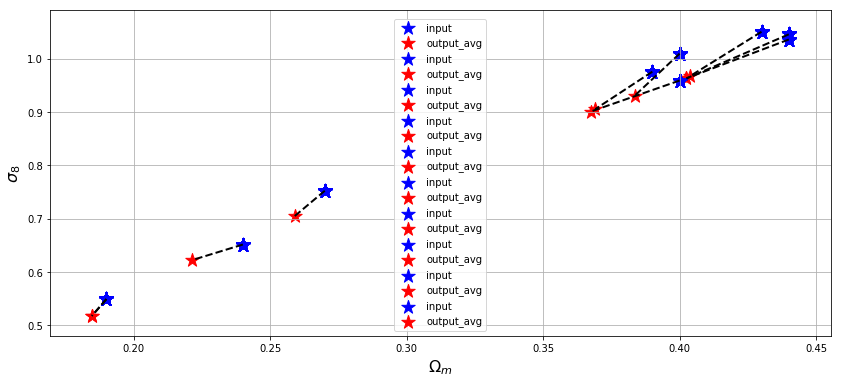

save model to : ./src/model1.1.1Llocal/440.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  440 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 525s 35s/step - loss: 6.8267e-04 - mean_squared_error: 6.8267e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 2/10
15/15 [==============================] - 517s 34s/step - loss: 7.8748e-04 - mean_squared_error: 7.8748e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 3/10
15/15 [==============================] - 514s 34s/step - loss: 6.2437e-04 - mean_squared_error: 6.2437e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 4/10
15/15 [==============================] - 515s 34s/step - loss: 6.3795e-04 - mean_squared_error: 6.3795e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 5/10
15/15 [==============================] - 515s 34s/step - loss: 7.7828e-04 - me

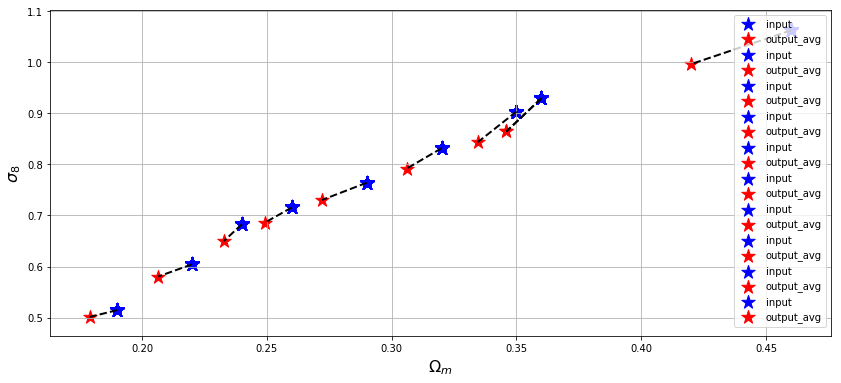

save model to : ./src/model1.1.1Llocal/450.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  450 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 516s 34s/step - loss: 5.3383e-04 - mean_squared_error: 5.3383e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/10
15/15 [==============================] - 504s 34s/step - loss: 7.3436e-04 - mean_squared_error: 7.3436e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/10
15/15 [==============================] - 505s 34s/step - loss: 6.9861e-04 - mean_squared_error: 6.9861e-04 - val_loss: 8.4327e-04 - val_mean_squared_error: 8.4327e-04
Epoch 4/10
15/15 [==============================] - 505s 34s/step - loss: 6.8868e-04 - mean_squared_error: 6.8868e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/10
15/15 [==============================] - 507s 34s/step - loss: 7.8729e

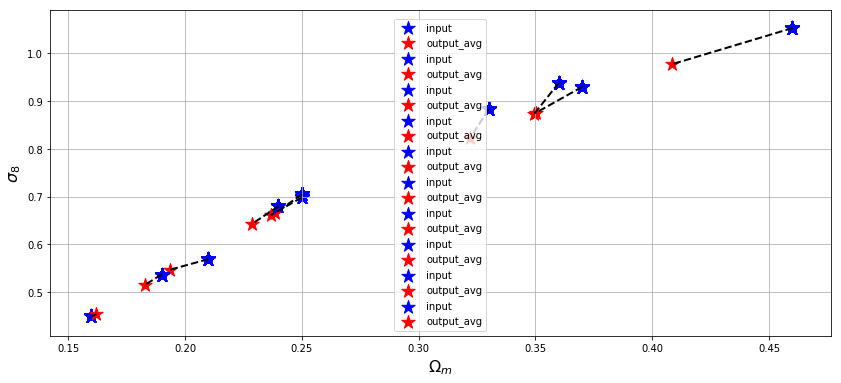

save model to : ./src/model1.1.1Llocal/460.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  460 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 517s 34s/step - loss: 6.6556e-04 - mean_squared_error: 6.6556e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 2/10
15/15 [==============================] - 502s 33s/step - loss: 5.5138e-04 - mean_squared_error: 5.5138e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 3/10
15/15 [==============================] - 504s 34s/step - loss: 5.9706e-04 - mean_squared_error: 5.9706e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 4/10
15/15 [==============================] - 504s 34s/step - loss: 6.1527e-04 - mean_squared_error: 6.1527e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/10
15/15 [==============================] - 506s 34s/step - loss: 5.5533e-04 - me

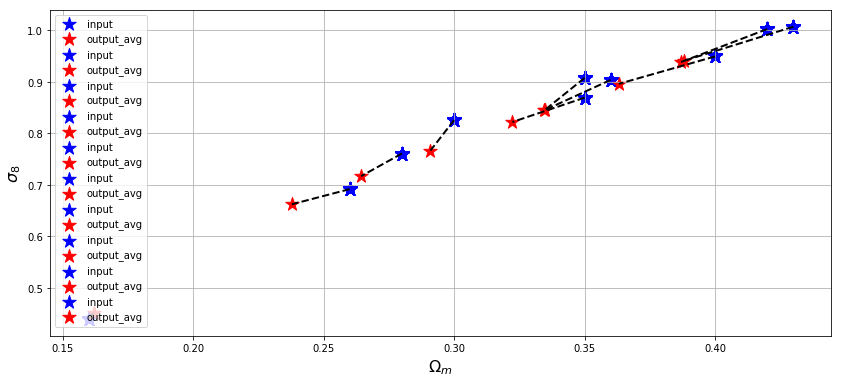

save model to : ./src/model1.1.1Llocal/470.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  470 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 519s 35s/step - loss: 6.1016e-04 - mean_squared_error: 6.1016e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 2/10
15/15 [==============================] - 504s 34s/step - loss: 6.1503e-04 - mean_squared_error: 6.1503e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 3/10
15/15 [==============================] - 505s 34s/step - loss: 6.2112e-04 - mean_squared_error: 6.2112e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/10
15/15 [==============================] - 506s 34s/step - loss: 5.8397e-04 - mean_squared_error: 5.8397e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 5/10
15/15 [==============================] - 508s 34s/step - loss: 5.9954e-04 - me

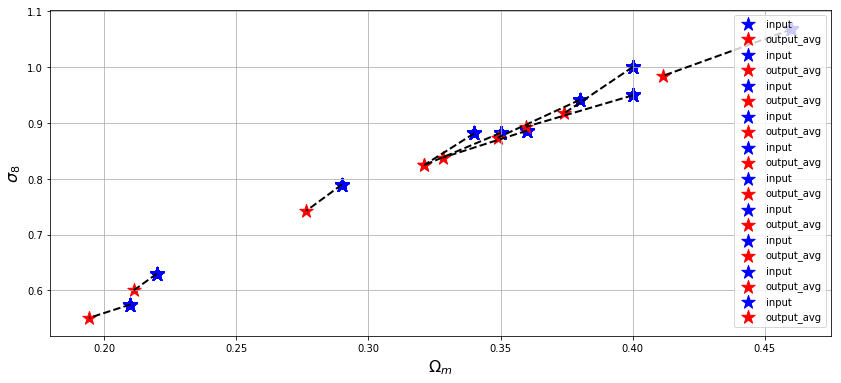

save model to : ./src/model1.1.1Llocal/480.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  480 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 521s 35s/step - loss: 6.3613e-04 - mean_squared_error: 6.3613e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 2/10
15/15 [==============================] - 505s 34s/step - loss: 6.1252e-04 - mean_squared_error: 6.1252e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 3/10
15/15 [==============================] - 509s 34s/step - loss: 6.0802e-04 - mean_squared_error: 6.0802e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/10
15/15 [==============================] - 507s 34s/step - loss: 4.9714e-04 - mean_squared_error: 4.9714e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 5/10
15/15 [==============================] - 508s 34s/step - loss: 5.3325e-04 - me

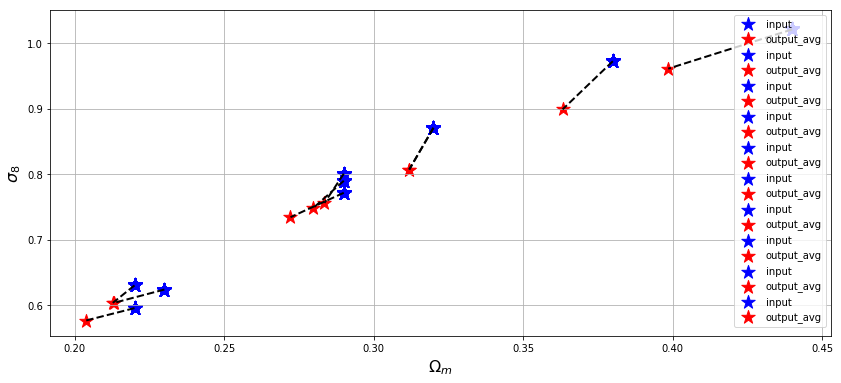

save model to : ./src/model1.1.1Llocal/490.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  490 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 526s 35s/step - loss: 5.2396e-04 - mean_squared_error: 5.2396e-04 - val_loss: 6.6826e-04 - val_mean_squared_error: 6.6826e-04
Epoch 2/10
15/15 [==============================] - 513s 34s/step - loss: 5.6478e-04 - mean_squared_error: 5.6478e-04 - val_loss: 5.8563e-04 - val_mean_squared_error: 5.8563e-04
Epoch 3/10
15/15 [==============================] - 514s 34s/step - loss: 5.6170e-04 - mean_squared_error: 5.6170e-04 - val_loss: 5.0619e-04 - val_mean_squared_error: 5.0619e-04
Epoch 4/10
15/15 [==============================] - 512s 34s/step - loss: 4.9485e-04 - mean_squared_error: 4.9485e-04 - val_loss: 5.7262e-04 - val_mean_squared_error: 5.7262e-04
Epoch 5/10
15/15 [==============================] - 511s 

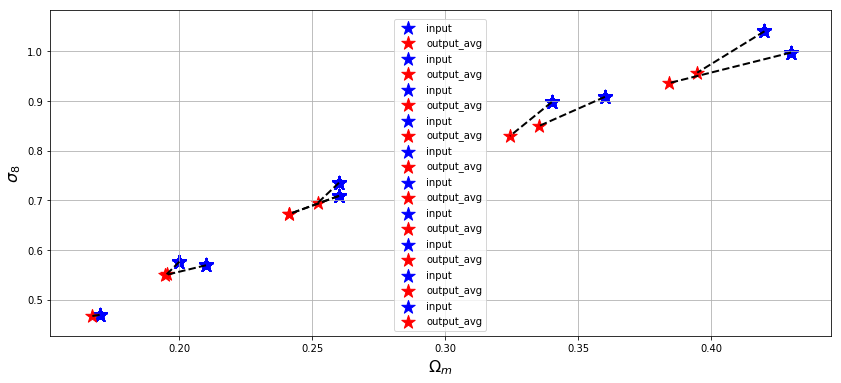

save model to : ./src/model1.1.1Llocal/500.save
###############################################
Begin training for src/model1.1.1Llocal, current epochs =  500 ; max_epochs =  500 ...
###############################################
Epoch 1/10
15/15 [==============================] - 525s 35s/step - loss: 4.5953e-04 - mean_squared_error: 4.5953e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 2/10
15/15 [==============================] - 511s 34s/step - loss: 4.6642e-04 - mean_squared_error: 4.6642e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 3/10
15/15 [==============================] - 515s 34s/step - loss: 4.9459e-04 - mean_squared_error: 4.9459e-04 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 4/10
15/15 [==============================] - 513s 34s/step - loss: 5.3799e-04 - mean_squared_error: 5.3799e-04 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 5/10
15/15 [==============================] - 516s 34s/step - loss: 5.9864e-04 - me

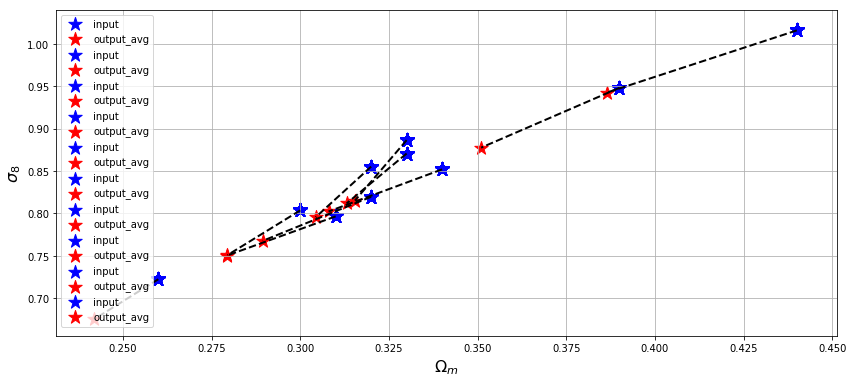

save model to : ./src/model1.1.1Llocal/510.save


In [8]:
epochs = 280

nowmodel = keras.models.load_model('/home/xiaodongli/projects/AI/src/model1.1.1Llocal/280.save')

step_epoch = 10

while epochs <= max_epochs:

    print('###############################################')
    print('Begin training for '+modelname+', current epochs = ', epochs, '; max_epochs = ', max_epochs, '...')
    print('###############################################')
    outputf.write('###############################################\n')
    outputf.write('Begin training for '+modelname+', current epochs = '+ str(epochs)+ '; max_epochs = '+str( max_epochs)+ '...\n')
    outputf.write('###############################################\n')

    if True:
        nowmodel.fit_generator(train_generator(),
                    steps_per_epoch=465//batch_size,  # 数据规格可能大小不对应
                    epochs=step_epoch,
                    verbose=1,
                    validation_data=(x_test,y_test))
    epochs += step_epoch

    filepath = './'+modelname+'/'+str(epochs)+'.save'
    # Plot validation
    if True:
        fig, ax = None, None
        for row in range(10):
            x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
            fig, ax = plot_test(nowmodel, x_test, y_test, fig=fig, ax=ax)
        ax.grid(); plt.show()
        ax.set_title('#-epochs = '+str(epochs), fontsize=16)
        fig.savefig(filepath+'.png', format='png')
    print('save model to :', filepath )
    outputf.write('save model to :'+str(filepath)+ '\n')
    keras.models.save_model(nowmodel, filepath)

outputf.close()
